<a href="https://colab.research.google.com/github/duyilemi/ViT-Base_Implementation/blob/main/ViT_Base_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer (ViT) Implementation  
*From "An Image is Worth 16x16 Words" (Dosovitskiy et al., 2020)*  

## Overview  
🖼️ What: Implementation of Vision Transformer(Base)

🧠 Why:  
- Explore transformer architectures beyond NLP  
- Reproduce key results from landmark CV paper  

⚙️ How:  
1. Paper Implementation: Patch embeddings, multi-head attention, [CLS] token  
2. Adaptation: Modified for Food-101 subset (3 classes)  
3. Visualization: Patch decomposition, attention patterns  

## Key Features  
✅ From-Scratch Implementation: No Huggingface shortcuts  
✅ Interactive Demos: Upload your own food images!  
✅ Performance Metrics: Accuracy/loss tracking  
✅ Paper Comparisons: Table 1 hyperparameters  

## Learning Objectives  
By the end of this notebook, you'll understand:  
1. How transformers process images as sequences  
2. ViT's architectural components (positional embeddings, etc.)  

## Technical Requirements  
- Google Colab (GPU runtime recommended)  
- Basic PyTorch familiarity  
- 1+ GB disk space for dataset  

*Citation*:  
Dosovitskiy et al. (2020). [An Image is Worth 16x16 Words](https://arxiv.org/abs/2010.11929)  
Dataset: [Food-101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) (subset)

## Setup & Config

Paper Reference: Table 1 (ViT-Base Hyperparameters)

*Key configuration matching the original paper's ViT-Base/16 architecture*

In [ ]:
import torch
from torch import nn

# Hyperparameters (ViT-Base/16)
IMG_SIZE = 224        # Input image size (224x224 pixels)
PATCH_SIZE = 16       # Size of each image patch (16x16 pixels)
EMBED_DIM = 768       # Dimension of patch embeddings (D in paper)
MLP_SIZE = 3072       # Hidden layer size in MLP block (4*D when D=768)
NUM_HEADS = 12        # Number of attention heads in MSA
NUM_LAYERS = 12       # Number of transformer blocks
DROPOUT = 0.1         # Dropout rate for regularization
NUM_CLASSES = 3       # Number of classes (pizza, steak, sushi)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Patch Embeddings

*Paper Reference: Eq. 1, Section 3.1*

How Transformers "See" Images:
Vision Transformers process images differently from CNNs. Instead of scanning with filters, they:

+ Split the image into small 16x16 pixel squares (like cutting a photo into puzzle pieces)

+ Flatten each patch into a 1D vector

+ Project through a neural network layer to create "patch embeddings" (convert visual patterns to numbers transformers understand)

This converts a 224x224 image into 196 sequence elements (224/16 = 14 → 14x14 grid = 196 patches), similar to how language models process words in a sentence.

In [ ]:
class PatchEmbedding(nn.Module):
    """Turns images into sequence of transformer-ready vectors"""
    def __init__(self):
        super().__init__()
        # Creates a "patch cutter" using a convolution layer
        self.patcher = nn.Conv2d(
            in_channels=3,          # Input color channels (RGB)
            out_channels=EMBED_DIM,  # Output embedding dimension
            kernel_size=PATCH_SIZE,  # Patch size (16x16)
            stride=PATCH_SIZE        # Non-overlapping patches
        )

        # Flattens spatial dimensions (height/width -> sequence length)
        self.flatten = nn.Flatten(2, 3)

    def forward(self, x):
        # Input shape: [batch, 3, 224, 224]
        x = self.patcher(x)    # Cut into patches → [batch, 768, 14, 14]
        x = self.flatten(x)    # Flatten → [batch, 768, 196]
        x = x.permute(0, 2, 1) # Rearrange → [batch, 196, 768]
        return x

### Demo: Visualizing Patch Embeddings

This interactive demo lets you:

+ Upload any image

+ Watch how ViT transforms pixels into patch embeddings

+ Understand the shape changes through the system

What you'll see:

+ Raw image → Tensor → Sequence of 768-dim embeddings

+ 196 patches created from a 224x224 image (14x14 grid)

+ Each patch becomes a "visual word" for the transformer

Saving images (7).jpeg to images (7).jpeg

--- Image Shape Transformation Demo ---
Original image shape: (690, 445) (Width x Height)
Preprocessed tensor shape: torch.Size([1, 3, 224, 224]) (Batch x Channels x Height x Width)

After Patch Embedding:
Shape: torch.Size([1, 196, 768]) (Batch x Sequence Length x Embedding Dimension)
Sequence length: 196 patches
Each patch representation: 768 numbers


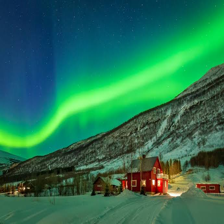

In [ ]:
# Import necessary libraries for image handling
from IPython.display import display
from PIL import Image
import torchvision.transforms as transforms
from google.colab import files


# Image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize to model's expected input
    transforms.ToTensor(),                    # Convert to PyTorch tensor
])

# Upload and process an image
uploaded = files.upload()  # This will prompt a file upload dialog
uploaded_image = next(iter(uploaded))  # Get first uploaded file

# Open and preprocess image
img = Image.open(uploaded_image)
img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

print("\n--- Image Shape Transformation Demo ---")
print(f"Original image shape: {img.size} (Width x Height)")
print(f"Preprocessed tensor shape: {img_tensor.shape} (Batch x Channels x Height x Width)")

# Create patch embedding layer
patch_embedder = PatchEmbedding()

# Process through patch embedding
patch_embeddings = patch_embedder(img_tensor)

print(f"\nAfter Patch Embedding:")
print(f"Shape: {patch_embeddings.shape} (Batch x Sequence Length x Embedding Dimension)")
print(f"Sequence length: {patch_embeddings.shape[1]} patches")
print(f"Each patch representation: {patch_embeddings.shape[2]} numbers")

# Show the uploaded image
display(img.resize((224, 224)))  # Display resized version

### Demo: See How ViT Splits Images
What This Code Does:

Visualizes the exact 16x16 pixel patches ViT uses from your uploaded image.

You'll See:
+ Original image → 224x224 resized version
+ 14x14 grid of patches (196 total)
+ Each patch labeled with its (row, column) position

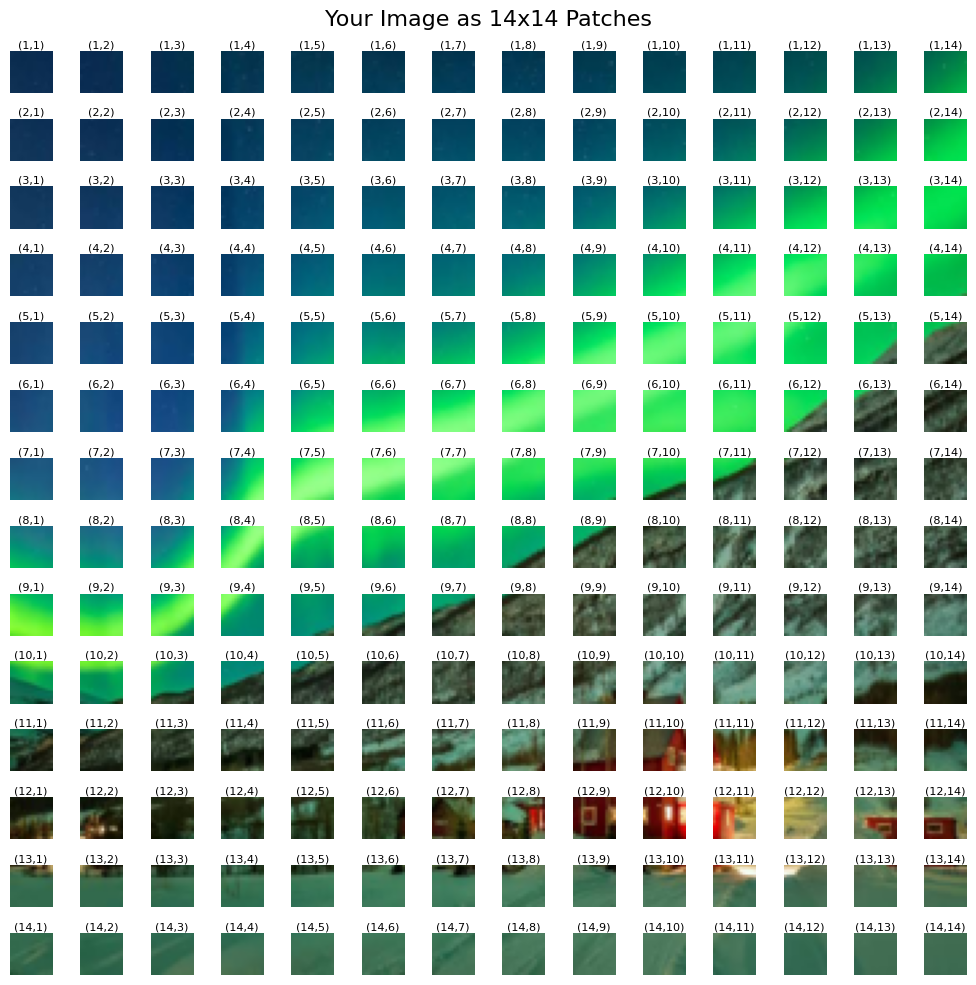

In [ ]:
import matplotlib.pyplot as plt

# Check if image exists (run after uploading)
if 'img_tensor' not in globals() or img_tensor.shape[-2:] != (224, 224):
    print("No compatible image found! Run the 'Upload Image' cell first.")
else:
    # Patch parameters
    img_size = 224
    patch_size = 16
    num_patches = img_size // patch_size

    # Convert tensor -> numpy for plotting
    image_permuted = img_tensor.squeeze(0).permute(1, 2, 0).numpy()

    # Create patch grid
    fig, axs = plt.subplots(num_patches, num_patches, figsize=(10, 10))

    # Plot each patch with coordinates
    for i in range(num_patches):
        for j in range(num_patches):
            # Get patch boundaries
            y_start, y_end = i*patch_size, (i+1)*patch_size
            x_start, x_end = j*patch_size, (j+1)*patch_size

            axs[i,j].imshow(image_permuted[y_start:y_end, x_start:x_end, :])
            axs[i,j].set_title(f"({i+1},{j+1})", fontsize=8, pad=2)
            axs[i,j].axis('off')

    plt.suptitle(f"Your Image as {num_patches}x{num_patches} Patches", fontsize=16)
    plt.tight_layout()
    plt.show()

## Class Token & Position Embeddings

*Paper Reference: Section 3.1*

Giving the Model Spatial Awareness:
Transformers need help understanding where patches are located, just like humans need to know if a nose patch belongs above a mouth patch.

Two crucial additions:

1.Positional Embeddings

+ Learned "location codes" added to each patch

+ Without these, the model would see patches in random order

2.[CLS] Token

+ Special "summary token" added at the start (position 0)

+ Doesn't represent any specific patch

+ Gradually collects information about the whole image

+ Acts like a book's summary paragraph that gets updated as you read

Sequence Transformation Example:
[196 patches] → [CLS] + [196 patches] = 197 elements

In [ ]:

# Initialize learnable components
class_token = nn.Parameter(torch.randn(1, 1, EMBED_DIM))  # [CLS] token
position_embed = nn.Parameter(torch.randn(1, 197, EMBED_DIM)) # Positions 0-196

def add_special_tokens(x):
    """Adds [CLS] token and position info to patch sequence"""
    batch_size = x.shape[0]

    # Step 1: Add [CLS] token to start
    cls_token = class_token.expand(batch_size, -1, -1)  # Copy for batch
    x = torch.cat([cls_token, x], dim=1)  # New shape: [batch, 197, 768]

    # Step 2: Add position codes (learned GPS for patches)
    x += position_embed
    return x

## Transformer Encoder
*Paper Reference: Eq. 2-3, Section 3.1*

The Transformer's "Thinking" Process:
The encoder helps patches communicate and understand their relationships through two key operations:

### 1.Multi-Head Self-Attention

+ Lets every patch "look" at other patches and the [CLS] token
+ Discovers relationships
+ Multiple "heads" find different types of relationships simultaneously

In [ ]:
class MSABlock(nn.Module):
    """Patch communication center"""
    def __init__(self):
        super().__init__()
        self.norm = nn.LayerNorm(EMBED_DIM)  # Standardize inputs
        self.attn = nn.MultiheadAttention(
            EMBED_DIM, NUM_HEADS, batch_first=True
        )

    def forward(self, x):
        identity = x  # Preserve original
        x = self.norm(x)
        # All patches talk to each other
        x, _ = self.attn(x, x, x)  # (query, key, value)
        return x + identity  # Add new insights to original

### 2.Feedforward Network

+ Refines each position's understanding using insights from attention

+ Adds complexity to the representations

In [ ]:
class MLPBlock(nn.Module):
    """Deep feature refiner"""
    def __init__(self):
        super().__init__()
        self.norm = nn.LayerNorm(EMBED_DIM)
        self.mlp = nn.Sequential(
            nn.Linear(EMBED_DIM, MLP_SIZE),  # Expand
            nn.GELU(),                       # Non-linear
            nn.Dropout(DROPOUT),             # Regularize
            nn.Linear(MLP_SIZE, EMBED_DIM),  # Compress
            nn.Dropout(DROPOUT)
        )

    def forward(self, x):
        return self.mlp(self.norm(x)) + x  # Enhance features

### Full Encoder Layer
*Paper Reference: Figure 1 (Transformer encoder)*

In [ ]:
class TransformerBlock(nn.Module):
    """Complete transformer block (MSA + MLP)"""
    def __init__(self):
        super().__init__()
        self.msa = MSABlock()
        self.mlp = MLPBlock()

    def forward(self, x):
        x = self.msa(x)
        x = self.mlp(x)
        return x


*Key Design:*

+ Uses residual connections (keeps original info while adding new insights)
+ Processes all patches in parallel (unlike CNNs' sequential processing)

## Classification Head
*Paper Reference: Eq. 4*

After processing through all transformer layers:

+ The [CLS] token becomes an "image summary" containing information from all patches

+ This summary is passed through a simple neural network (the "MLP Head")

+ Final output predicts whether the image is pizza, steak, or sushi

Why [CLS]?

+ Positioned at start of sequence to gather global information

In [ ]:
class ClassifierHead(nn.Module):
    """Turns [CLS] summary into food predictions"""
    def __init__(self):
        super().__init__()
        self.norm = nn.LayerNorm(EMBED_DIM)  # Final tune-up
        self.fc = nn.Linear(EMBED_DIM, NUM_CLASSES)  # Decision maker

    def forward(self, x):
        # Extract [CLS] token (first in sequence)
        cls_summary = x[:, 0, :]  # Shape: [batch, 768]

        # Process through final layers
        tuned_summary = self.norm(cls_summary)
        return self.fc(tuned_summary)  # Shape: [batch, 3]

## Full ViT Architecture
*Paper Reference: Figure 1 (Full model diagram)*

End-to-End Flow:

1. Patchify image → 196 patches

2. Add [CLS] token & position info

3. Process through transformer layers

4. Classify using [CLS] token

In [ ]:
class ViT(nn.Module):
    """Complete Vision Transformer (No Separate Special Tokens Function)"""
    def __init__(self):
        super().__init__()
        # 1. Patch embedding generator
        self.patch_embed = PatchEmbedding()

        # 2. Transformer encoder stack
        self.transformer = nn.Sequential(*[
            TransformerBlock()
            for _ in range(NUM_LAYERS)
        ])

        # 3. Classification head
        self.head = ClassifierHead()

        # 4. Special tokens parameters
        self.class_token = nn.Parameter(torch.randn(1, 1, EMBED_DIM))
        self.position_embed = nn.Parameter(torch.randn(1, 197, EMBED_DIM))

    def forward(self, x):
        # 1. Create patch embeddings
        x = self.patch_embed(x)  # [batch, 196, 768]

        # 2. Add [CLS] token directly in forward
        cls_tokens = self.class_token.expand(x.shape[0], -1, -1)  # Expand to batch size
        x = torch.cat([cls_tokens, x], dim=1)  # [batch, 197, 768]

        # 3. Add position embeddings directly
        x += self.position_embed

        # 4. Process through transformer
        x = self.transformer(x)

        # 5. Classify using [CLS] token
        return self.head(x)

## Training Setup
*Paper Reference: Table 3 (Training parameters)*

In [ ]:
model = ViT()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

### Visual summary of the model

In [ ]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


# Print a summary of the ViT model using torchinfo
summary(model=model,
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         # col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
 )

[INFO] Couldn't find torchinfo... installing it.


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embed)                     [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                            [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                           [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Sequential (transformer)                         [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerBlock (0)                        [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─MSABlock (msa)                         [32, 197, 768]       [32, 197, 768]       2,363,904            True
│    │    └─MLPBlock (mlp)                   

### Get Data

The ViT model will be trained and evaluated on a custom subset of Food-101.

3-Class Food Classification:

🍕 Pizza (Italian dish with dough and toppings)

🥩 Steak (Cooked beef cut, typically grilled/pan-seared)

🍣 Sushi (Japanese vinegared rice with seafood)

Key Details:

Source: Subsampled from Food-101 Dataset

In [ ]:
import os
import zipfile
from pathlib import Path
import requests

# Download function
def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/duyilemi/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/duyilemi/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

#### Create Datasets and DataLoaders

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

NUM_WORKERS = os.cpu_count()

# Create dataloader function
def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78b0f7d01310>,
 ['pizza', 'steak', 'sushi'])

#### Visualize some random images

<ipython-input-19-2126126c93f3>:26: UserWarning: Glyph 127829 (\N{SLICE OF PIZZA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-19-2126126c93f3>:26: UserWarning: Glyph 129385 (\N{CUT OF MEAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127829 (\N{SLICE OF PIZZA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129385 (\N{CUT OF MEAT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


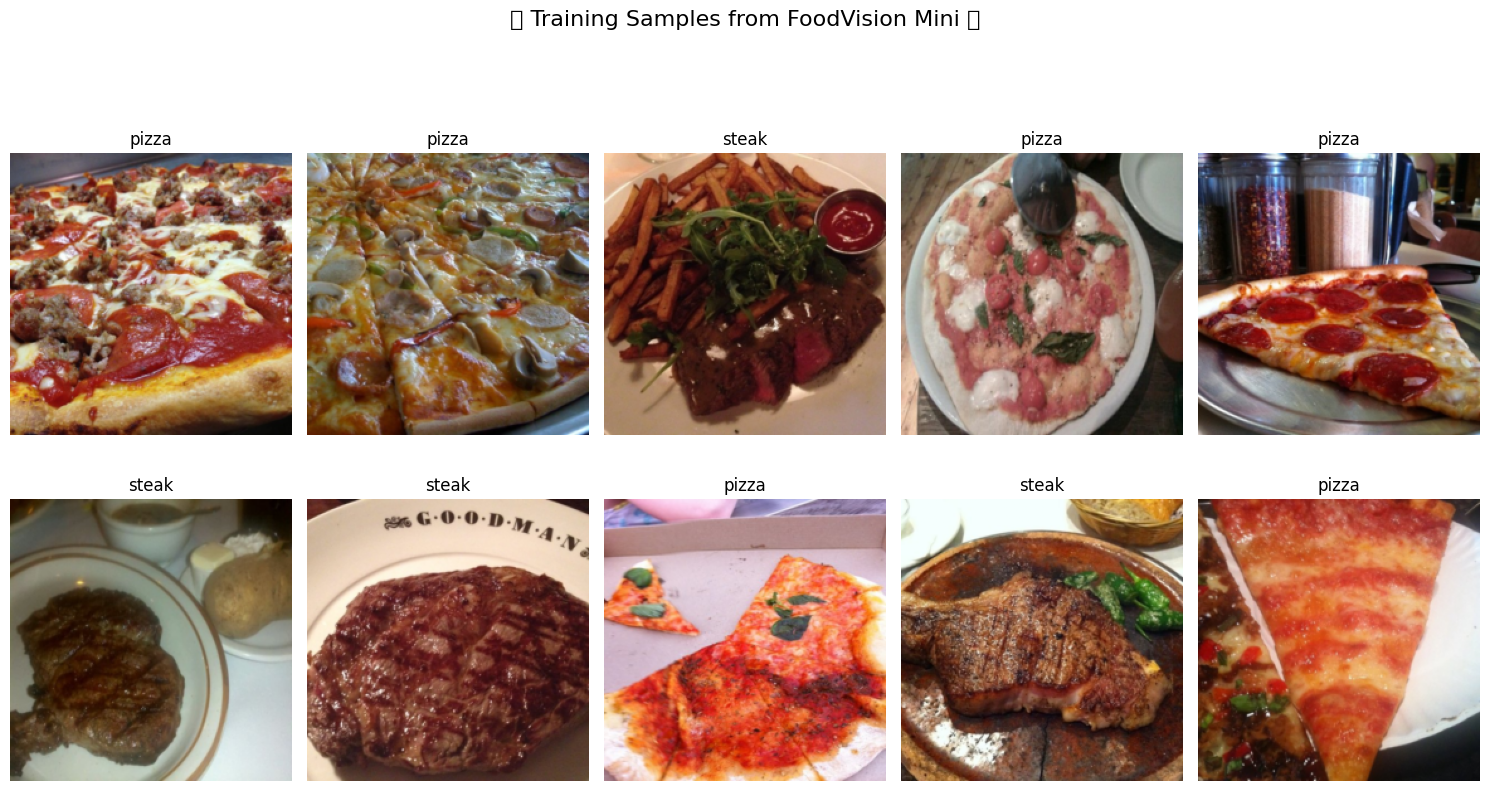

In [ ]:
# Get 10 random samples from train dataloader
num_images = 10
images, labels = next(iter(train_dataloader))

# Randomly select 10 indices
random_indices = torch.randperm(len(images))[:num_images]
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Create plot
plt.figure(figsize=(15, 8))
plt.suptitle("🍕 Training Samples from FoodVision Mini 🥩", fontsize=16, y=1.05)

for i, (image, label) in enumerate(zip(selected_images, selected_labels)):
    # Create subplot
    ax = plt.subplot(2, 5, i+1)

    # Reverse normalization if needed (uncomment if you normalized your data)
    # image = image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

    # Plot image with class label
    plt.imshow(image.permute(1, 2, 0).clamp(0, 1))  # Clamp for potential float values
    plt.title(f"{class_names[label]}", fontsize=12)
    plt.axis(False)

plt.tight_layout()
plt.show()

#### Training Function

In [ ]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

#### Finally, let's train the model

In [ ]:
# Train the model and save the training results to a dictionary
results = train(model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0008 | train_acc: 0.3945 | test_loss: 1.7996 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.7319 | train_acc: 0.3242 | test_loss: 1.0589 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.2658 | train_acc: 0.3164 | test_loss: 1.1844 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.3246 | train_acc: 0.2852 | test_loss: 1.0395 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.1280 | train_acc: 0.4141 | test_loss: 1.5307 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.1491 | train_acc: 0.2891 | test_loss: 1.0660 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.1563 | train_acc: 0.3086 | test_loss: 1.0369 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.2294 | train_acc: 0.3047 | test_loss: 1.1585 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.0781 | train_acc: 0.4297 | test_loss: 1.2831 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.1257 | train_acc: 0.2969 | test_loss: 1.1099 | test_acc: 0.1979


#### Plot the loss curves

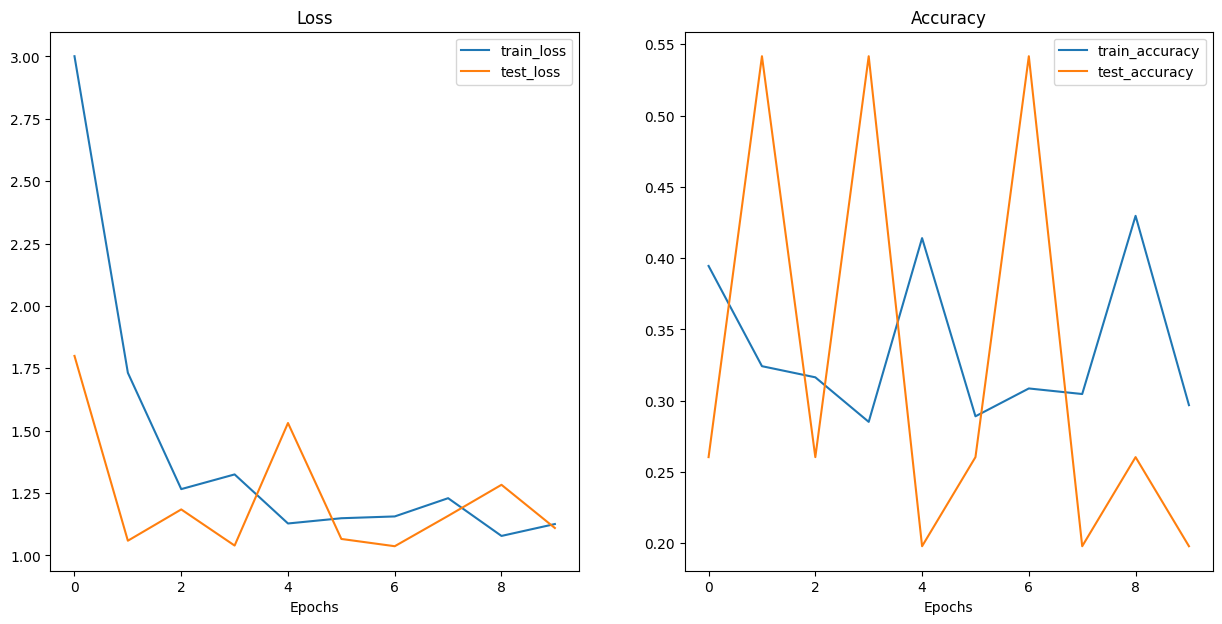

In [ ]:
# Function for plotting loss curves
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

# Plot our ViT model's loss curves
plot_loss_curves(results)